# Retraining the 3D Unet


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time
import h5py
from importlib import reload

# 3D visualization tools
#from mayavi import mlab
#mlab.init_notebook(backend='ipy')
#mlab.options.backend = 'envisage'
import tensorflow as tf

In [2]:
# Import modules providing tools for image manipulation
import sys
sys.path.append('../../tools')
import mosaic, deformation, affine
sys.path.append('..')
import utilities, model
reload(utilities) 

<module 'utilities' from '..\\utilities.py'>

In [3]:
# Fix for tensorflow-gpu issues that I found online... (don't ask me what it does)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Data Input Pipeline

The whole dataset has a size in the order of terabytes. At this stage we only work with preextracted volumes of (220px)^3 size.
Heavy use of data augumentation should enable the network to learn efficiently from a very low number of annotated samples.

the utilities module offers a custom keras.util.Sequence object that performs real time data augumentation. At the moment these operations consume a lot of time and could take up a lot of additional time


In [4]:
# Load images and masks from preprocessed hdf5 files
#base_dir = 'C:\\Users\\lillvisj\\linus\\'
base_dir = 'C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\'
h5_paths = [base_dir+'dataset_0727']#, base_dir+'dataset_0724']
h5_files = [h5py.File(path) for path in h5_paths]
[print(h5_file.keys()) for h5_file in h5_files]

images = []
masks = []

for h5_file in h5_files:
    assert set(h5_file['image'].keys()) == set(h5_file['mask'].keys()), 'check that both branches of the directory contain the same keys'

    for key in h5_file['image'].keys():
        images.append(h5_file['image/'+key][...][...,np.newaxis]) # load whole array from h5 to numpy (first bracket [...]) 
        #then append a new axis for the channel dimension
        masks.append(h5_file['mask/'+key][...][...,np.newaxis].astype(np.int32))

    print('Imported {} image mask pairs with shapes {} (image) and {} (mask)'.format(len(images),images[0].shape,masks[0].shape))

#NOTE the dataset was allready preprocessed
# pixel values are cliped, shifted and scaled
# the masks are binarized

<KeysViewHDF5 ['image', 'mask']>
Imported 50 image mask pairs with shapes (220, 220, 220, 1) (image) and (132, 132, 132, 1) (mask)


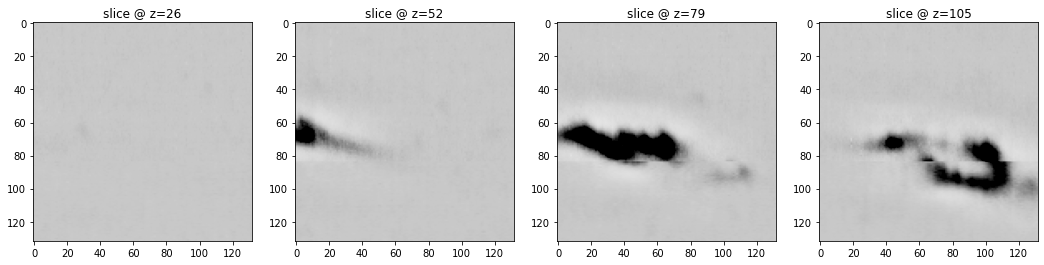

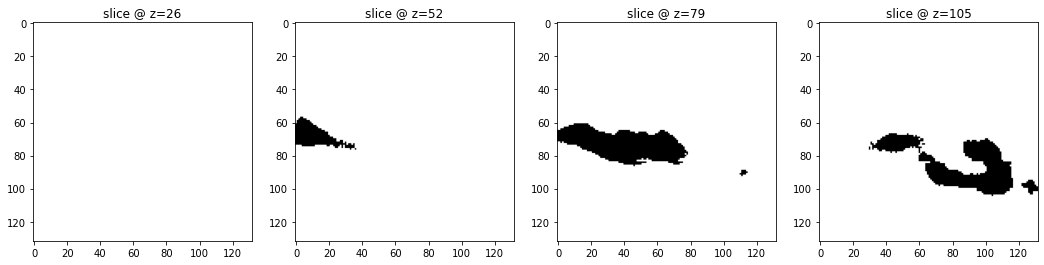

In [5]:
# validate the dataset
img = images[9]
utilities.showZSlices(img[44:176,44:176,44:176], mode='gray', vmin=-5, vmax=10)
msk = masks[9]
utilities.showZSlices(msk, mode='gray', vmin=0, vmax=1)

In [6]:
#TODO explore techniques to speed up image augumentation and batch preparation
train_sequence = utilities.Dataset3D(batch_size=1, batches = 40, images=images[:100], masks=masks[:100], mask_crop=0, augument=True, elastic=False, affine=True)
test_sequence  = utilities.Dataset3D(batch_size=1, batches = 10, images=images[100:], masks=masks[100:], mask_crop=0, augument= True, elastic=False, affine=True)

## Training the Unet

In [7]:
reload(model)

<module 'model' from '..\\model.py'>

In [9]:
# Define the model (build is triggered on first call)
unet = model.build_unet(input_shape=(220,220,220,1), n_blocks=2, initial_filters=4)


In [10]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 22 0                                            
__________________________________________________________________________________________________
input_block (InputBlock)        ((None, 108, 108, 10 984         input_1[0][0]                    
__________________________________________________________________________________________________
downsample_block (DownsampleBlo ((None, 52, 52, 52,  5208        input_block[0][0]                
__________________________________________________________________________________________________
downsample_block_1 (DownsampleB ((None, 24, 24, 24,  20784       downsample_block[0][0]           
______________________________________________________________________________________________

In [11]:
# Calculate the ratio of neuron to background pixels in the training set so that we can adjust class weights
object_ratio = np.mean(np.stack(masks)) # mean = sum / tot_pixels = the proportion of class label 1
object_weight = 1 / object_ratio # devide by proportion of cases to factor out imbalance of case numbers
background_weight = 1 / (1-object_ratio)
print('class weights background (0) * {:.3f} objects (1) * {:.3f}'.format(background_weight, object_weight))# 

class weights background (0) * 1.032 objects (1) * 32.638


In [14]:
img, msk = test_sequence.__getitem__(0)

In [12]:
unet.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = model.weighted_sparse_categorical_crossentropy(class_weights=[1,5])
             )

In [13]:
history = unet.fit(train_sequence, epochs=40,
                   validation_data= test_sequence,
                   callbacks=[tf.keras.callbacks.ModelCheckpoint('3d_unet_0727.h5', save_best_only=True)])
                       

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 10 steps
Epoch 1/40
40/40 [==============================] - 516s 13s/step - loss: 0.1667 - val_loss: 0.0214
Epoch 2/40
40/40 [==============================] - 512s 13s/step - loss: 0.0271 - val_loss: 0.0197
Epoch 3/40
40/40 [==============================] - 512s 13s/step - loss: 0.0253 - val_loss: 0.0186
Epoch 4/40
40/40 [==============================] - 516s 13s/step - loss: 0.0238 - val_loss: 0.0220
Epoch 5/40
40/40 [==============================] - 509s 13s/step - loss: 0.0228 - val_loss: 0.0244
Epoch 6/40
40/40 [==============================] - 506s 13s/step - loss: 0.0210 - val_loss: 0.0125
Epoch 7/40
40/40 [==============================] - 509s 13s/step - loss: 0.0226 - val_loss: 0.0311
Epoch 8/40
40/40 [==============================] - 509s 13s/step - loss: 0.0216 - val_loss: 0.0285
Epoch 9/40
40/40 [==============================] - 516s 13s/step - loss: 0.0232 - val_loss: 0.0189
Epoch 10

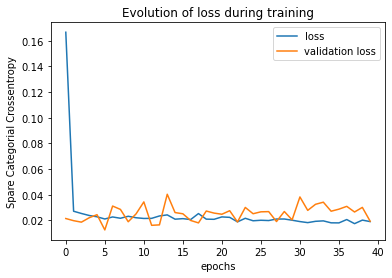

In [14]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','validation loss'])
plt.title('Evolution of loss during training')
plt.xlabel('epochs')
plt.ylabel('Spare Categorial Crossentropy')
plt.savefig('3d_unet_0727.png')

In [18]:
# enable elastic deformations and train some more
train_sequence = utilities.Dataset3D(batch_size=4, batches = 40, images=images[:100], masks=masks[:100], mask_crop=0, augument=True, elastic=True, affine=True)

In [28]:
history2 = unet.fit(train_sequence, epochs=15,
                   validation_data= test_sequence,
                   callbacks=[tf.keras.callbacks.ModelCheckpoint('3d_unet_0728.h5', save_best_only=True)])
                       

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 10 steps
Epoch 1/15
40/40 [==============================] - 1960s 49s/step - loss: 0.0248 - val_loss: 0.0292
Epoch 2/15
40/40 [==============================] - 1990s 50s/step - loss: 0.0275 - val_loss: 0.0183
Epoch 3/15
40/40 [==============================] - 1992s 50s/step - loss: 0.0275 - val_loss: 0.0171
Epoch 4/15
40/40 [==============================] - 1993s 50s/step - loss: 0.0261 - val_loss: 0.0274
Epoch 5/15
40/40 [==============================] - 1982s 50s/step - loss: 0.0259 - val_loss: 0.0231
Epoch 6/15
40/40 [==============================] - 1988s 50s/step - loss: 0.0267 - val_loss: 0.0225
Epoch 7/15
40/40 [==============================] - 1978s 49s/step - loss: 0.0250 - val_loss: 0.0214
Epoch 8/15
40/40 [==============================] - 1981s 50s/step - loss: 0.0242 - val_loss: 0.0286
Epoch 9/15
40/40 [==============================] - 1989s 50s/step - loss: 0.0286 - val_loss: 0.0323

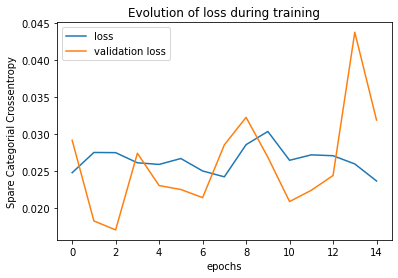

In [30]:
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['loss','validation loss'])
plt.title('Evolution of loss during training')
plt.xlabel('epochs')
plt.ylabel('Spare Categorial Crossentropy')
plt.savefig('3d_unet_0728.png')

In [7]:
model_path = 'C:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\3D Unet\\retrain0727\\3d_unet_0728.h5'
# Restore the trained model. Specify where keras can find custom objects that were used to build the unet
unet = tf.keras.models.load_model(model_path, compile=False,
                                  custom_objects={"InputBlock" : model.InputBlock,
                                                    "DownsampleBlock" : model.DownsampleBlock,
                                                    "BottleneckBlock" : model.BottleneckBlock,
                                                    "UpsampleBlock" : model.UpsampleBlock,
                                                    "OutputBlock" : model.OutputBlock})

In [47]:
#reload(utilities)
test_batch = train_sequence.__getitem__(2)
test_batch[0].shape
#plt.hist(test_batch[0].flat, log=True)

(1, 220, 220, 220, 1)

(1, 132, 132, 132, 2)


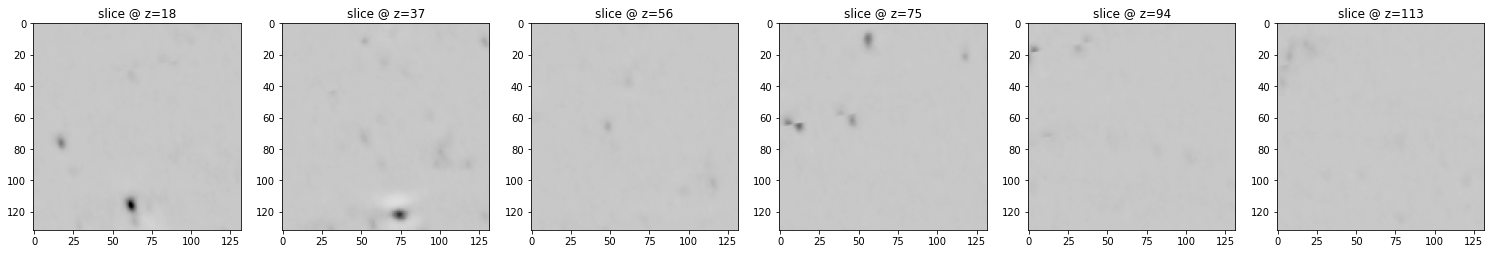

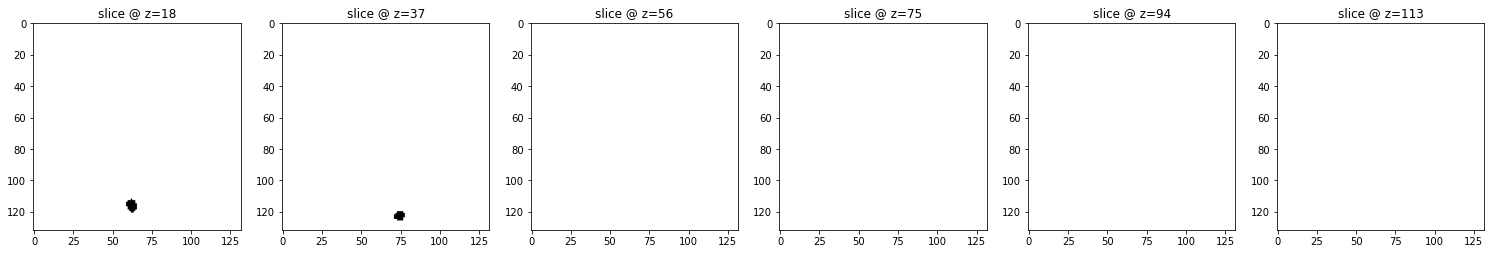

In [48]:
# get sample predictions on the test data
sample_prediction = unet.predict(test_batch[0])
print(sample_prediction.shape)
sample_prediction_mask = utilities.segmentationMask(sample_prediction)
utilities.showZSlices(test_batch[0][0,44:176,44:176,44:176,:], mode='gray', vmin=-5, vmax=10, n_slices=6)
utilities.showZSlices(sample_prediction_mask[0], mode='gray', vmin=0, vmax=1, n_slices=6)

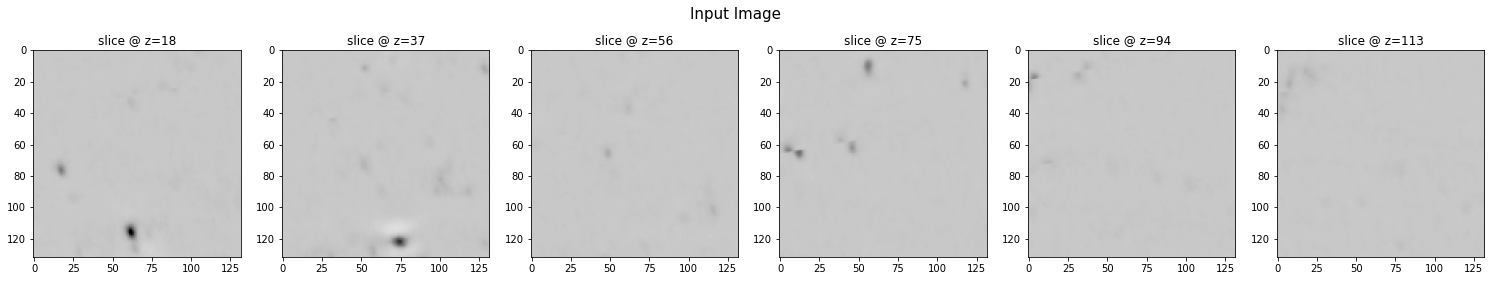

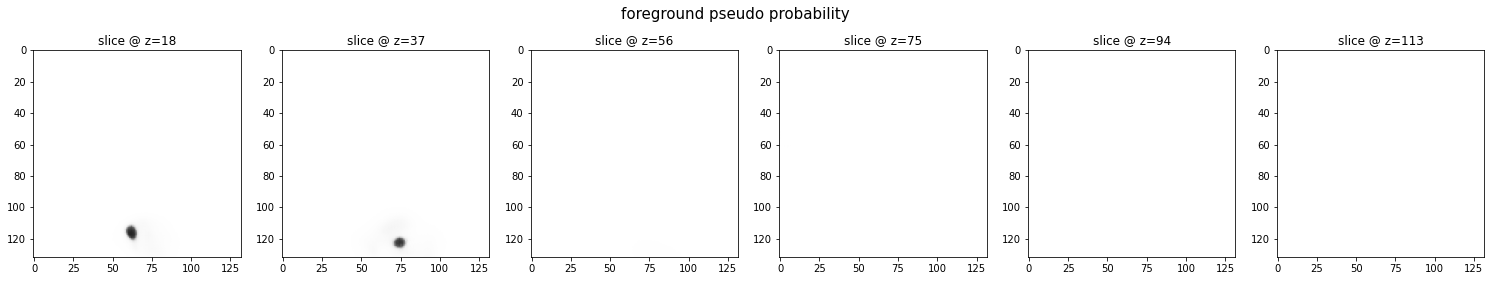

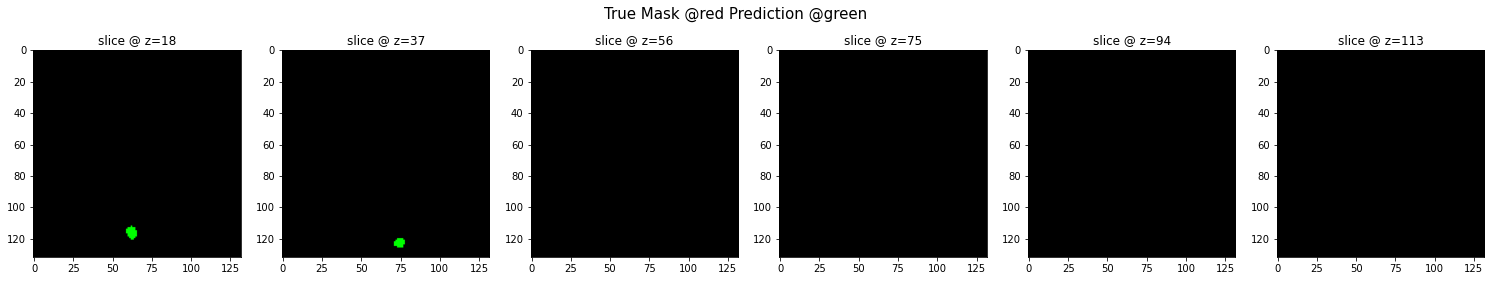

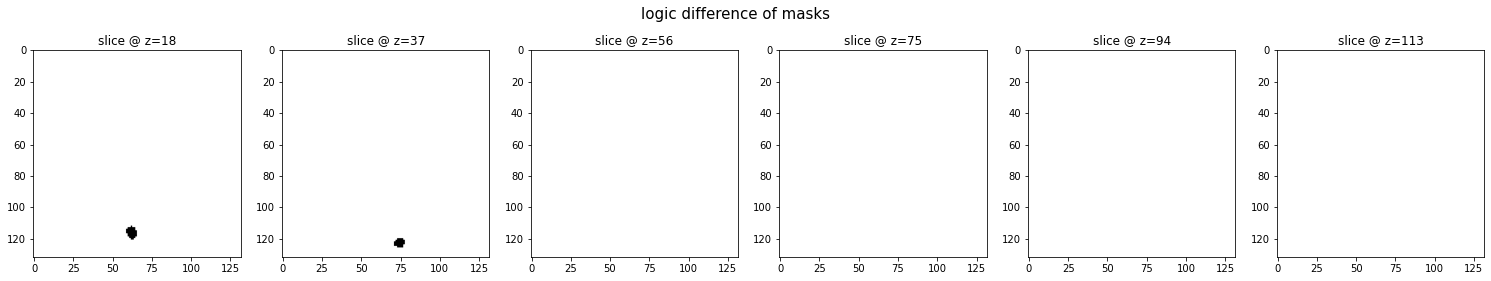

In [49]:
# Prediction evaluation cockpit 
utilities.showZSlices(test_batch[0][0,44:176,44:176,44:176,:], channel=0, n_slices=6, title='Input Image',vmin=-5, vmax=10)
prob = utilities.applySoftmax(sample_prediction)
utilities.showZSlices(prob[0], channel=1,n_slices=6, title='foreground pseudo probability', vmin=0, vmax=1)
mask_overlay = utilities.makeRGBComposite(r=test_batch[1], g=sample_prediction_mask,b=None, gain=255) # Make an overlay of the true mask (red) and the predicted mask (green)
utilities.showZSlices(mask_overlay[0],n_slices=6, mode='rgb', title='True Mask @red Prediction @green')
logic_diff = sample_prediction_mask !=  test_batch[1]
utilities.showZSlices(logic_diff[0], channel=0, n_slices=6, title='logic difference of masks')

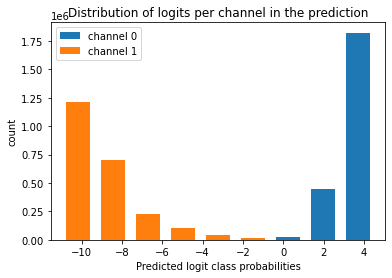

In [50]:
utilities.showLogitDistribution(sample_prediction)